In [11]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 118.6 MB/s eta 0:00:00


Redes Neuronales Convolucionales
=
Clasificación de imágenes de bananos según su estado de madurez.

Aplicaciones en los procesos de cosecha, selección poscocecha y distribución comercial.


---


**`Clases a clasificar:`**

*   freshripe = Maduro fresco/recién cosechado
*   freshunripe = Verde fresco/recién cosechado
*   unripe = Verde
*   overripe = Demasiado maduro
*   ripe = Maduro
*   rotten = Podrido


Se tiene de un total de ***`23334`*** imágenes de banano, divididas en ***`70%`*** para el entrenamiento del modelo, ***`15%`*** para la validación y ***`15%`*** para la fase de pruebas.

### Definir la red

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Red(nn.Module):

    def __init__(self):
        super(Red, self).__init__()
        # imagen de 3 canales (RGB), 6 filtros de salida, dimensiones de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 6 canales de entrada , 16 filtros de salida, dimensiones de 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # calcular total de características por imagen: y = Wx + b
        self.fc1 = nn.Linear(16 * 53 * 53, 1000) # vector 1D
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 6) # 6 clases de salida

    # operaciones
    def forward(self, entrada):
        # Capa convolucional C1: recibe 1 imagen de 3 canales (RGB), produce 6 filtros de salidas, de dimensión 5x5 con activación ReLU
        # y genera un tensor de tamaño (N, 6, 220, 220), donde N es el tamaño del batch
        # ReLU = 0 negativos, = positivos
        c1 = F.relu(self.conv1(entrada))
        #print("C1: Salidas y dimensiones:",c1.shape)
        # Capa de reducción de dimensionalidad: max-pooling 2x2, salida (N, 6, 110, 110), donde N es el tamaño del batch
        s2 = F.max_pool2d(c1, (2, 2))
        #print("S2: Salidas y dimensiones:"s2.shape)
        # Capa convolucional C3: 6 canales de entrada, 16 filtros de salida, dimensión de 5x5 con activación ReLU y genera un Tensor de (N, 16, 106, 106)
        c3 = F.relu(self.conv2(s2))
        #print("C3: Salidas y dimensiones:",c3.shape)
        # Capa de reducción de dimensionalidad: max-pooling 2x2, salida (N, 16, 53, 53), donde N es el tamaño del batch
        s4 = F.max_pool2d(c3, 2)
        #print("Salidas y dimensiones:",s4.shape)
        # Operación de aplanamiento: convierte el tensor (N, 16, 53, 53) en un vector de 1D (N, 44944), donde N es el tamaño del batch.
        s4 = torch.flatten(s4, 1)
        #print("Flatten: Salidas y dimensiones:",s4.shape)
        # Capa totalmente conectada F5: entrada (44944), salida (120) con activación ReLU
        f5 = F.relu(self.fc1(s4))
        #print("F5: Salidas y dimensiones:",f5.shape)
        # Capa totalmente conectada F6: entrada (120), salida (84) con activación ReLU
        f6 = F.relu(self.fc2(f5))
        #print("F6: Salidas y dimensiones:",f6.shape)
        # Capa de salida (F7): entrada (84), salida (6) -> capa de clasificación
        salida = self.fc3(f6)

        return salida


red = Red()
print(red)

Red(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
)


### Cargar dataset
En esta sección se carga todo el dataset de imágenes que se van a utilizar para entrenar, validar y probar el modelo.

In [2]:
# cargar dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import os

# descomprimir dataset
ruta = "../content/Banana_Ripeness"
rutas = [os.path.join(ruta, "train"), os.path.join(ruta, "test")]
with zipfile.ZipFile(ruta + ".zip", 'r') as zip_ref:
        zip_ref.extractall(ruta)

# transformar a tensor y normalizar dataset para tener valores en un rango de [-1, 1], acelera el aprendizaje y la congervencia
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

batch_size = 32
# entrenamiento (70%)
training_data = datasets.ImageFolder(
    root=rutas[0],
    transform=transform
)
# test (15%)
test_data = datasets.ImageFolder(
    root=rutas[1],
    transform=transform
)

# tamaño de test
n_test = len(test_data)

# dividir train en validación (15%)
indices = list(range(len(training_data)))
train_indices, val_indices = train_test_split(indices, test_size=n_test, random_state=42, shuffle=True)

#dividir train y val
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

# crear variables para datos de entrenamiento, validación y pruebas / DATALOADERS
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Datos de entrenamiento (70%):",len(train_data))
print("Datos de validación (15%):",len(val_data))
print("Datos de prueba (15%):",len(test_data))
print("Datos totales (100%):",len(train_data)+len(test_data)+len(val_data))
# obtener clases
clases=('freshripe','freshunripe','unripe','overripe','ripe','rotten')
print("Clases:",clases)

Datos de entrenamiento (70%): 16332
Datos de validación (15%): 3501
Datos de prueba (15%): 3501
Datos totales (100%): 23334
Clases: ('freshripe', 'freshunripe', 'unripe', 'overripe', 'ripe', 'rotten')


### Obtener caractertisticas y etiquetas de las imágenes

In [3]:
#obtener caracteristicas de imagenes y etiquetas
train_features, train_labels = next(iter(train_dataloader))
print(f"Tamaño de lote, canales y dimensiones: {train_features.size()}")
print(f"Número de etiquetas por cada lote: {train_labels.size()}")

Tamaño de lote, canales y dimensiones: torch.Size([32, 3, 224, 224])
Número de etiquetas por cada lote: torch.Size([32])


### Definir función de pérdida y optimizador
Mediante está función se optimiza el proceso de aprendizaje de la red a través de la Gradiente Descendente

In [4]:
import torch.optim as optim
# función de perdida: mide que tan bién clasificó la red aplicando probabilidad y comparando con la clase correcta.
criterio = nn.CrossEntropyLoss()
# momentum sirve para acelerar el proceso de encontrar el valor más cercano a cero
# ajuste de pesos mediante la Gradiente Descendente Estocástico
optimizador = optim.SGD(red.parameters(), lr=0.001, momentum=0.9)
print(optimizador)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Configurar uso de GPU
Buscar dispositivo (GPU/CPU) disponible para acelerar entrenamiento

In [5]:
# elección de arquitectura
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando:",device)

# Mover el modelo a GPU/CPU
red.to(device)

Usando: cuda


Red(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
)

### Entrenamiento de la CNN
Entrenamiento de la CNN mediante el uso del datos de entrenamiento en un número específico de épocas, dónde por cada una de estas se busca y actualiza el mejor modelo según la pérdida con los datos de validación.

In [6]:
# Entrenamiento de modelo
mejor_modelo = None
menor_perdida = float("inf")
m_epoca = 0
train_perdida = []
train_precision = []
n_epocas=30

for epoca in range(n_epocas):  # número de épocas
    red.train() # entrenamiento
    running_loss = 0.0
    for entradas, etiquetas in train_dataloader:
        # mover datos a GPU/CPU
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # gradiente de ceros
        optimizador.zero_grad()

        # forward + backward + optimize = backpropagation = propagación hacia atrás
        salidas = red(entradas) # envío
        perdida = criterio(salidas, etiquetas) # calculo diferencia o pérdida
        perdida.backward() # Actualiza pesos
        optimizador.step() # optimiza/ajusta pesos
        running_loss += perdida.item() # almacena perdida acumulada

    # pérdida promedio por época
    perdida_promedio = running_loss / len(train_dataloader)
    print(f"[Epoca {epoca+1} | perdida promedio: {perdida_promedio:.3f}]")

    # validación
    red.eval()
    correcto, total, val_perdida = 0, 0, 0.0
    with torch.no_grad(): # no se usa gradiente
      for entradas, etiquetas in val_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        salidas = red(entradas)
        perdida_val = criterio(salidas, etiquetas)
        val_perdida += perdida_val.item()
        _, pred = torch.max(salidas, 1) # índices de los valores más altos por cada imagen
        total += etiquetas.size(0)
        correcto += (pred == etiquetas).sum().item() # convertir tensor escalar a un número entero

    # perdida y ganancia por época
    val_perdida /= len(val_dataloader)
    val_acc = 100 * correcto / total
    train_precision.append(val_acc)
    print(f"|=== Validación -> Precision {val_acc:0.2f}% | Pérdida {val_perdida:0.2f} ===|")

 # guardar mejor modelo
    if val_perdida < menor_perdida:
        menor_perdida = val_perdida
        m_epoca = epoca+1
        mejor_modelo = red.state_dict()
    # almacenar perdidas en train_perdida
    train_perdida.append(perdida_promedio)
print('='*60)
print(f"[👌Modelo con menor perdida: {menor_perdida:0.5f}, Epoca {m_epoca}]")
print('Entrenamiento finalizado')

[Epoca 1 | perdida promedio: 1.537]
|=== Validación -> Precision 53.07% | Pérdida 1.19 ===|
[Epoca 2 | perdida promedio: 1.062]
|=== Validación -> Precision 59.53% | Pérdida 1.04 ===|
[Epoca 3 | perdida promedio: 0.868]
|=== Validación -> Precision 67.18% | Pérdida 0.82 ===|
[Epoca 4 | perdida promedio: 0.766]
|=== Validación -> Precision 66.18% | Pérdida 0.83 ===|
[Epoca 5 | perdida promedio: 0.697]
|=== Validación -> Precision 72.61% | Pérdida 0.69 ===|
[Epoca 6 | perdida promedio: 0.619]
|=== Validación -> Precision 72.61% | Pérdida 0.68 ===|
[Epoca 7 | perdida promedio: 0.560]
|=== Validación -> Precision 70.75% | Pérdida 0.75 ===|
[Epoca 8 | perdida promedio: 0.500]
|=== Validación -> Precision 76.95% | Pérdida 0.60 ===|
[Epoca 9 | perdida promedio: 0.432]
|=== Validación -> Precision 76.95% | Pérdida 0.61 ===|
[Epoca 10 | perdida promedio: 0.375]
|=== Validación -> Precision 77.49% | Pérdida 0.59 ===|
[Epoca 11 | perdida promedio: 0.314]
|=== Validación -> Precision 78.49% | Pérd

### Guardar mejor modelo

In [7]:
ruta = './mejor_modelo_banana.pth'
torch.save(mejor_modelo, ruta)

### Cargar modelo entrenado

In [12]:
modelo = Red()
modelo.load_state_dict(torch.load(ruta, weights_only=True))
modelo.to(device)
modelo.eval() # evaluar modelo

# Crear un input de ejemplo con el mismo tamaño que tus imágenes
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Exportar a ONNX
torch.onnx.export(
    modelo,
    dummy_input,
    "cnn_modelo.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

print("Modelo cargado")

/tmp/ipython-input-269304415.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Modelo cargado


### Probar modelo
En esta sección se prueba el modelo con el fin de conocer la generalización de este ante los datos de test o prueba, y por ende calcular la precisión de este por cada clase.



In [14]:
# Prueba de modelo por cada clase
aciertos_clase = {classname: 0 for classname in clases}
total_pred_clase = {classname: 0 for classname in clases}

# no se necesita la gradiente ya que se entrena una sola vez
with torch.no_grad():
    for entradas, etiquetas in test_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        salidas = modelo(entradas)
        _, predicciones = torch.max(salidas, 1)
        # collección de predicciones correctas por cada clase
        for etiqueta, prediccion in zip(etiquetas, predicciones):
            if etiqueta == prediccion:
                aciertos_clase[clases[etiqueta]] += 1
            total_pred_clase[clases[etiqueta]] += 1


# mostrar precision por cada clase
for n_clase, conteo_correctas in aciertos_clase.items():
    accuracy = 100 * float(conteo_correctas) / total_pred_clase[n_clase]
    print(f'Precisión por clase: {n_clase:5s} es {accuracy:.2f} %')

Precisión por clase: freshripe es 86.29 %
Precisión por clase: freshunripe es 78.04 %
Precisión por clase: unripe es 83.11 %
Precisión por clase: overripe es 74.91 %
Precisión por clase: ripe  es 83.16 %
Precisión por clase: rotten es 81.71 %


### Precisión total
En esta sección se calcula la precisión total del modelo para clasificar todas las clases de madurez de banano.

In [15]:
# calcular precisión en test
correcto = 0
total = 0
# no se necesita la gradiente
with torch.no_grad():
    for entradas, etiquetas in test_dataloader:
        entradas, etiquetas = entradas.to(device), etiquetas.to(device)
        # calculate outputs by running images through the network
        salidas = modelo(entradas)
        # the class with the highest energy is what we choose as prediction
        _, prediccion = torch.max(salidas, 1)
        total += etiquetas.size(0)
        correcto += (prediccion == etiquetas).sum().item()
print(f'Preicisión del modelo con {len(test_data)} imagenes de test: {100 * correcto / total:.2f}%')

Preicisión del modelo con 3501 imagenes de test: 81.35%


### Visualización de resultados
En esta sección se muestra la curvas tanto de pérdida como la curva de precisón en entrenamiento.

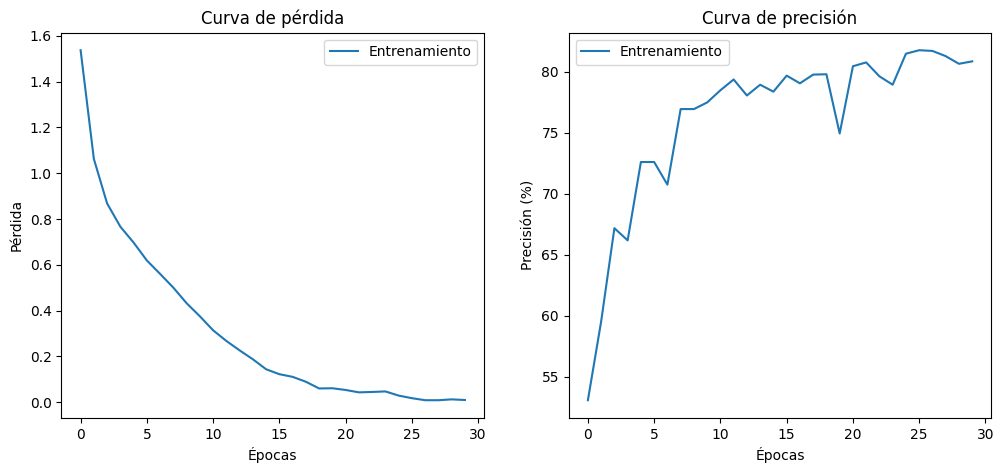

In [16]:
import matplotlib.pyplot as plt

# Curva de pérdida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_perdida, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1,2,2)
plt.plot(train_precision, label='Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Curva de precisión')
plt.legend()

plt.show()

### Mostrar imágenes

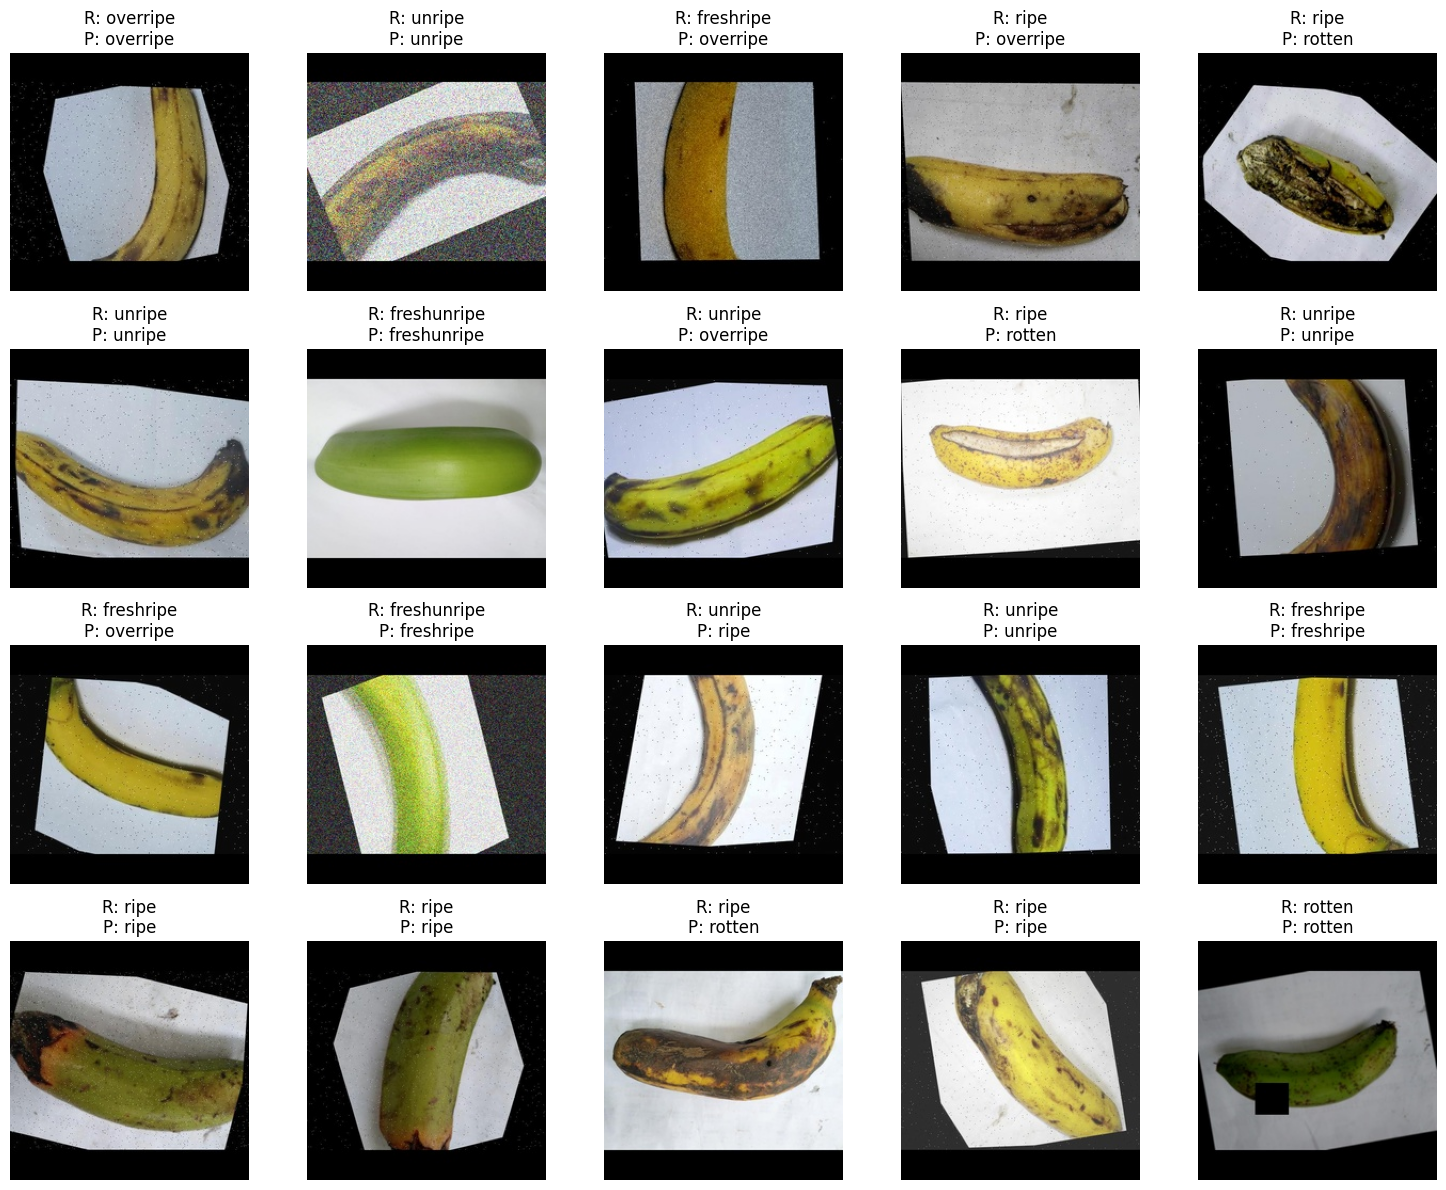

In [17]:
import math
import matplotlib.pyplot as plt

def mostrar_imagen(img, etiqueta_real, etiqueta_pred):
    # Reordenar canales de [Canal,Alto,Ancho] a [Alto,Ancho,Canal]
    img = img.permute(1, 2, 0)
    # Desnormalizar (0.5,...),(0.5,...)
    img = img * 0.5 + 0.5 # [0, 1]
    img = img.cpu().numpy() # mover a cpu
    plt.imshow(img.clip(0,1))
    plt.title(f"R: {clases[etiqueta_real]}\nP: {clases[etiqueta_pred]}")
    plt.axis("off")

def mostrar_imagenes(imagenes, etiquetas, predicciones, n=12):
    filas = math.ceil(n / 5)   # 5 columnas por fila
    cols = min(n, 5)
    plt.figure(figsize=(cols*3, filas*3))
    for i in range(n):
        plt.subplot(filas, cols, i+1)
        mostrar_imagen(imagenes[i], etiquetas[i].item(), predicciones[i].item())
    plt.tight_layout()
    plt.show()

# mostrar 20 imágenes
dataiter = iter(test_dataloader)
imagenes, etiquetas = next(dataiter)
# mover a GPU
imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
salidas = red(imagenes)
_, predicciones = torch.max(salidas, 1)

mostrar_imagenes(imagenes, etiquetas, predicciones, n=20)